<a href="https://colab.research.google.com/github/GaryGu12138/AI4EO-FInal-Project/blob/main/Vegetation_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2 Vegetation Change Detection Using CNN

#### 2.1 Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/MyDrive/vegetation_detection'

Mounted at /content/drive


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.4 MB/s eta 0:00:00


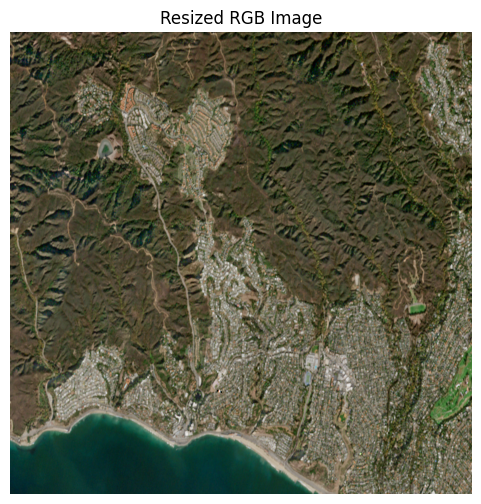

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.plot import show
from skimage.transform import resize
import matplotlib.pyplot as plt

before_path = os.path.join(root_dir,"before")
file_name = "2025-01-02-00_00_2025-01-02-23_59_Sentinel-2_L2A_True_color.tiff"
file_path = os.path.join(before_path, file_name)

with rasterio.open(file_path) as src:
  image_array = src.read()

  # resize image to 2448*2448
  resized_image = resize(image_array, (image_array.shape[0], 2448, 2448), mode='reflect', anti_aliasing=True)

  # format conversion
  resized_image = np.transpose(resized_image, (1, 2, 0))

  # normalization
  min_value = np.min(resized_image)
  max_value = np.max(resized_image)
  normalized_image = (resized_image - min_value) / (max_value - min_value) * 255.0
  normalized_image = normalized_image.astype(np.uint8)
  before_image = normalized_image

  # visualization
  plt.figure(figsize=(6, 6))
  plt.imshow(before_image)
  plt.title("Resized RGB Image")
  plt.axis('off')
  plt.show()

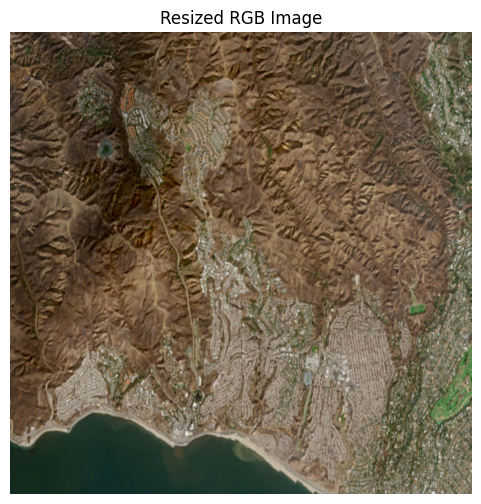

In [ ]:
after_path = os.path.join(root_dir,"after")
file_name = "2025-02-01-00_00_2025-02-01-23_59_Sentinel-2_L2A_True_color.tiff"
file_path = os.path.join(after_path, file_name)

with rasterio.open(file_path) as src:
  image_array = src.read()

  # resize image to 2448*2448
  resized_image = resize(image_array, (image_array.shape[0], 2448, 2448), mode='reflect', anti_aliasing=True)

  # format conversion
  resized_image = np.transpose(resized_image, (1, 2, 0))  # 转换为 (H, W, C) 格式

  # normalization
  min_value = np.min(resized_image)
  max_value = np.max(resized_image)
  normalized_image = (resized_image - min_value) / (max_value - min_value) * 255.0
  normalized_image = normalized_image.astype(np.uint8)
  after_image = normalized_image

  # visualization
  plt.figure(figsize=(6, 6))
  plt.imshow(after_image)
  plt.title("Resized RGB Image")
  plt.axis('off')
  plt.show()

#### 2.2 Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


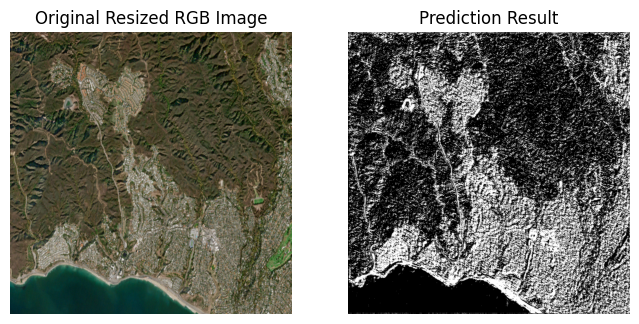

In [ ]:
from tensorflow.keras.models import load_model

###### load model
model_path = os.path.join(root_dir, "cnn.h5")
model = load_model(model_path)

###### prediction before wildfire
input_image = np.expand_dims(before_image, axis=0)
cnn_before_predictions = model.predict(input_image)
threshold = 0.7
cnn_before_predictions = (cnn_before_predictions > threshold).astype(np.uint8)

# visualization
plt.figure(figsize=(8, 4))

# original image
plt.subplot(1, 2, 1)
plt.imshow(before_image)
plt.title("Original Resized RGB Image")
plt.axis('off')

# predictive image
plt.subplot(1, 2, 2)
plt.imshow(cnn_before_predictions[0, :, :, 0], cmap='gray')  # 显示二值图
plt.title("Prediction Result")
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


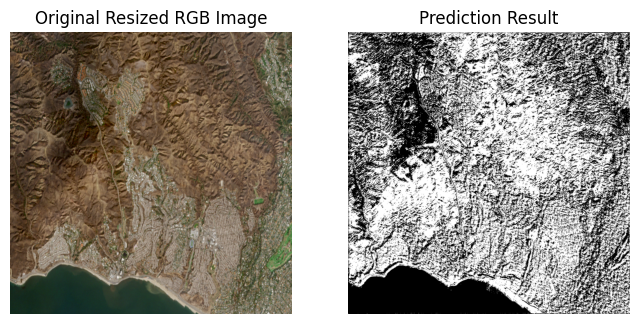

In [ ]:
###### prediction after wildfire
input_image = np.expand_dims(after_image, axis=0)
cnn_after_predictions = model.predict(input_image)
threshold = 0.7
cnn_after_predictions = (cnn_after_predictions > threshold).astype(np.uint8)

# visualization
plt.figure(figsize=(8, 4))

# original image
plt.subplot(1, 2, 1)
plt.imshow(after_image)
plt.title("Original Resized RGB Image")
plt.axis('off')

# predictive image
plt.subplot(1, 2, 2)
plt.imshow(cnn_after_predictions[0, :, :, 0], cmap='gray')
plt.title("Prediction Result")
plt.axis('off')

plt.show()

#### 2.3 Change Detection

In [ ]:
# summarize the number of vegetation pixels
before_vegetation_count = np.sum(cnn_before_predictions[0, :, :, 0])
after_vegetation_count = np.sum(cnn_after_predictions[0, :, :, 0])

print(f"Before vegetation pixel count: {2448*2448-before_vegetation_count}")
print(f"After vegetation pixel count: {2448*2448-after_vegetation_count}")

Before vegetation pixel count: 4080312
After vegetation pixel count: 2644952


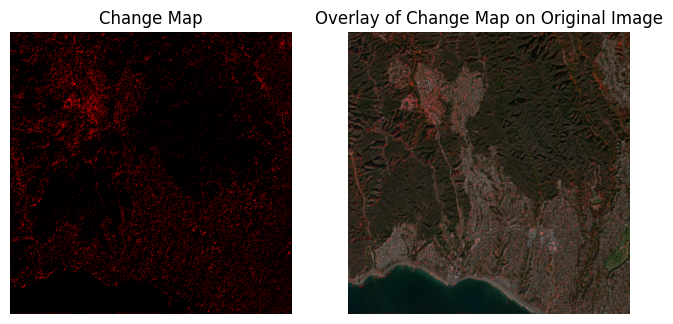

In [ ]:
# change map that marks the portions change from vegetated to non-vegetated in red
cnn_change_map = np.zeros_like(before_image)
cnn_change_map[:, :, 0] = 255*((cnn_before_predictions[0, :, :, 0] == 1) & (cnn_after_predictions[0, :, :, 0] == 0))

plt.figure(figsize=(8, 4))

# change map
plt.subplot(1, 2, 1)
plt.imshow(cnn_change_map)
plt.title("Change Map")
plt.axis('off')

# change map with basemap
plt.subplot(1, 2, 2)
plt.imshow(before_image)
plt.imshow(cnn_change_map, alpha=0.5)
plt.title("Overlay of Change Map on Original Image")
plt.axis('off')

plt.show()

## 3 Vegetation Change Detection Using NDVI & K-means

#### 3.1 Data Preparation

In [ ]:
file_name_b04 = "2025-01-02-00_00_2025-01-02-23_59_Sentinel-2_L2A_B04_(Raw).tiff"
file_name_b08 = "2025-01-02-00_00_2025-01-02-23_59_Sentinel-2_L2A_B08_(Raw).tiff"

file_path_b04 = os.path.join(before_path, file_name_b04)
file_path_b08 = os.path.join(before_path, file_name_b08)

with rasterio.open(file_path_b04) as src_b04, rasterio.open(file_path_b08) as src_b08:
  image_array_b04 = src_b04.read(1)
  image_array_b08 = src_b08.read(1)

  # resize
  before_resized_b04 = resize(image_array_b04, (2448, 2448), mode='reflect', anti_aliasing=True)
  before_resized_b08 = resize(image_array_b08, (2448, 2448), mode='reflect', anti_aliasing=True)

  # Combining B4 and B8 into a single feature
  before_features = np.stack([before_resized_b04, before_resized_b08], axis=-1)
  before_features_flat = before_features.reshape(-1, 2)  # resize into (n_samples, n_features)


In [ ]:
file_name_b04 = "2025-02-01-00_00_2025-02-01-23_59_Sentinel-2_L2A_B04_(Raw).tiff"
file_name_b08 = "2025-02-01-00_00_2025-02-01-23_59_Sentinel-2_L2A_B08_(Raw).tiff"

file_path_b04 = os.path.join(after_path, file_name_b04)
file_path_b08 = os.path.join(after_path, file_name_b08)

with rasterio.open(file_path_b04) as src_b04, rasterio.open(file_path_b08) as src_b08:
  image_array_b04 = src_b04.read(1)
  image_array_b08 = src_b08.read(1)

  # resize
  after_resized_b04 = resize(image_array_b04, (2448, 2448), mode='reflect', anti_aliasing=True)
  after_resized_b08 = resize(image_array_b08, (2448, 2448), mode='reflect', anti_aliasing=True)

  # Combining B4 and B8 into a single feature
  after_features = np.stack([after_resized_b04, after_resized_b08], axis=-1)
  after_features_flat = after_features.reshape(-1, 2)


#### 3.2 NDVI

<ipython-input-11-86a07be36858>:2: RuntimeWarning: invalid value encountered in divide
  before_ndvi = (before_resized_b08 - before_resized_b04) / (before_resized_b08 + before_resized_b04)


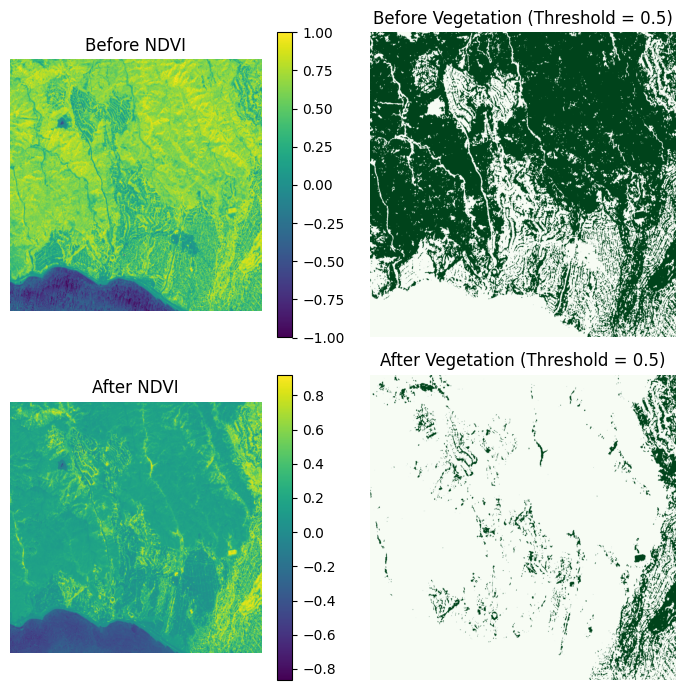

In [ ]:
# calculating NDVI
before_ndvi = (before_resized_b08 - before_resized_b04) / (before_resized_b08 + before_resized_b04)
ndvi_before_vegetation = before_ndvi > 0.5

after_ndvi = (after_resized_b08 - after_resized_b04) / (after_resized_b08 + after_resized_b04)
ndvi_after_vegetation = after_ndvi > 0.5

###### visualization
plt.figure(figsize=(7, 7))
# Before NDVI
plt.subplot(2, 2, 1)
plt.imshow(before_ndvi, cmap='viridis')
plt.colorbar()
plt.title("Before NDVI")
plt.axis('off')

# Before Vegetation
plt.subplot(2, 2, 2)
plt.imshow(ndvi_before_vegetation, cmap='Greens')
plt.title("Before Vegetation (Threshold = 0.5)")
plt.axis('off')

# After NDVI
plt.subplot(2, 2, 3)
plt.imshow(after_ndvi, cmap='viridis')
plt.colorbar()
plt.title("After NDVI")
plt.axis('off')

# After Vegetation
plt.subplot(2, 2, 4)
plt.imshow(ndvi_after_vegetation, cmap='Greens')
plt.title("After Vegetation (Threshold = 0.5)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# summarize the number of vegetation pixels
before_vegetation_count = np.sum(ndvi_before_vegetation)
after_vegetation_count = np.sum(ndvi_after_vegetation)

print(f"Before vegetation pixel count: {before_vegetation_count}")
print(f"After vegetation pixel count: {after_vegetation_count}")

Before vegetation pixel count: 3746642
After vegetation pixel count: 494992


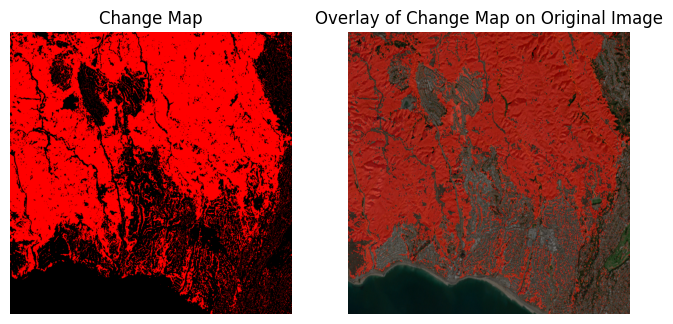

In [ ]:
# creating change map
ndvi_change_map = np.zeros((ndvi_before_vegetation.shape[0], ndvi_before_vegetation.shape[1], 3), dtype=np.uint8)

# Mark in red the portion of the vegetation that becomes non-vegetated
ndvi_change_map[:, :, 0] = 255 * ((ndvi_before_vegetation == 1) & (ndvi_after_vegetation == 0))

###### visualization
plt.figure(figsize=(8, 4))
# change map
plt.subplot(1, 2, 1)
plt.imshow(ndvi_change_map)
plt.title("Change Map")
plt.axis('off')

# change map with base map
plt.subplot(1, 2, 2)
plt.imshow(before_image)
plt.imshow(ndvi_change_map, alpha=0.5)
plt.title("Overlay of Change Map on Original Image")
plt.axis('off')

plt.show()

#### 3.3 K-means

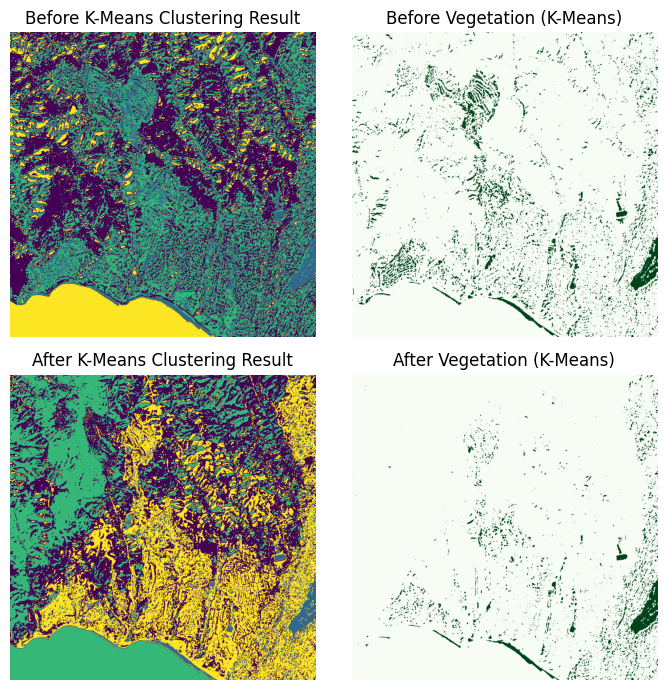

In [ ]:
from sklearn.cluster import KMeans

# Initialize the K-Means model
kmeans = KMeans(n_clusters=4, random_state=42)

# clustering before_features
kmeans.fit(before_features_flat)
before_labels = kmeans.labels_.reshape(before_features.shape[:2])
before_centroids = kmeans.cluster_centers_
before_vegetation_class = np.argmax(before_centroids[:, 1] - before_centroids[:, 0])
kmeans_before_vegetation = before_labels == before_vegetation_class

# clustering after_features
kmeans.fit(after_features_flat)
after_labels = kmeans.labels_.reshape(after_features.shape[:2])
after_centroids = kmeans.cluster_centers_
after_vegetation_class = np.argmax(after_centroids[:, 1] - after_centroids[:, 0])
kmeans_after_vegetation = after_labels == after_vegetation_class

###### visualization
plt.figure(figsize=(7, 7))
# Before K-Means
plt.subplot(2, 2, 1)
plt.imshow(before_labels, cmap='viridis')
plt.title("Before K-Means Clustering Result")
plt.axis('off')

# Before Vegetation
plt.subplot(2, 2, 2)
plt.imshow(kmeans_before_vegetation, cmap='Greens')
plt.title("Before Vegetation (K-Means)")
plt.axis('off')

# After K-Means
plt.subplot(2, 2, 3)
plt.imshow(after_labels, cmap='viridis')
plt.title("After K-Means Clustering Result")
plt.axis('off')

# After Vegetation
plt.subplot(2, 2, 4)
plt.imshow(kmeans_after_vegetation, cmap='Greens')
plt.title("After Vegetation (K-Means)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# summarize the number of vegetation pixels
before_vegetation_count = np.sum(kmeans_before_vegetation)
after_vegetation_count = np.sum(kmeans_after_vegetation)

print(f"Before vegetation pixel count: {before_vegetation_count}")
print(f"After vegetation pixel count: {after_vegetation_count}")

Before vegetation pixel count: 444560
After vegetation pixel count: 224697


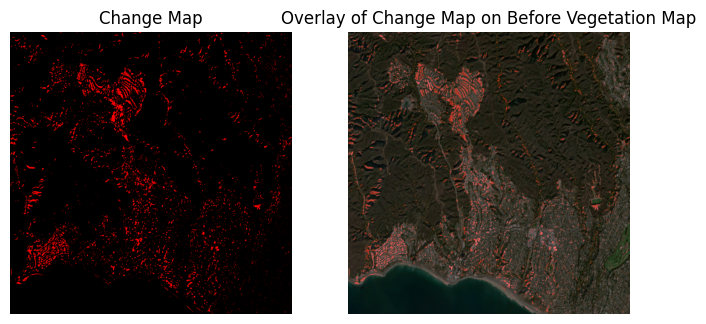

In [ ]:
# creating change map
kmeans_change_map = np.zeros((kmeans_before_vegetation.shape[0], kmeans_before_vegetation.shape[1], 3), dtype=np.uint8)

# Mark in red the portion of the vegetation that becomes non-vegetated
kmeans_change_map[:, :, 0] = 255 * ((kmeans_before_vegetation == 1) & (kmeans_after_vegetation == 0))

###### visualization
plt.figure(figsize=(8, 4))

# change map
plt.subplot(1, 2, 1)
plt.imshow(kmeans_change_map)
plt.title("Change Map")
plt.axis('off')

# change map with basemap
plt.subplot(1, 2, 2)
plt.imshow(before_image)
plt.imshow(kmeans_change_map, alpha=0.5)
plt.title("Overlay of Change Map on Before Vegetation Map")
plt.axis('off')

plt.show()

## 4 Conclusion

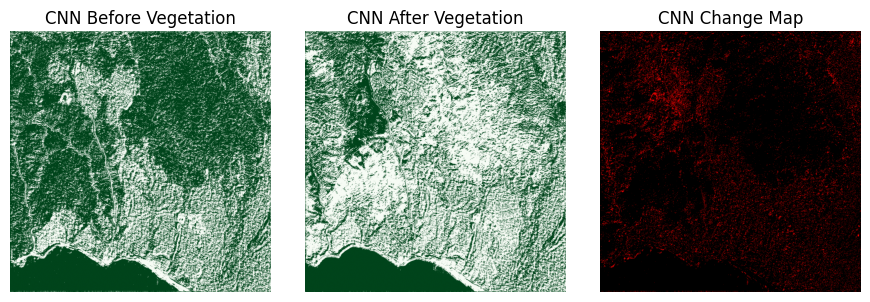

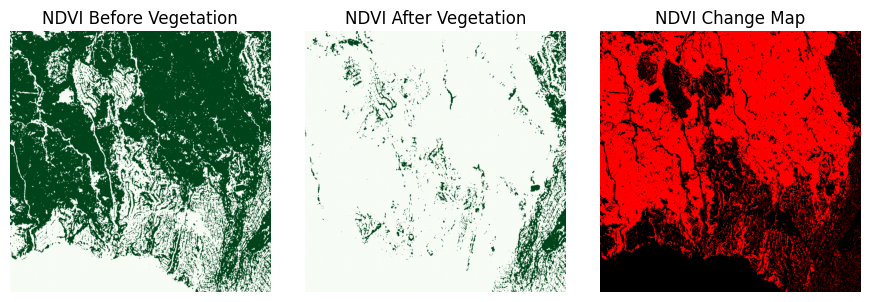

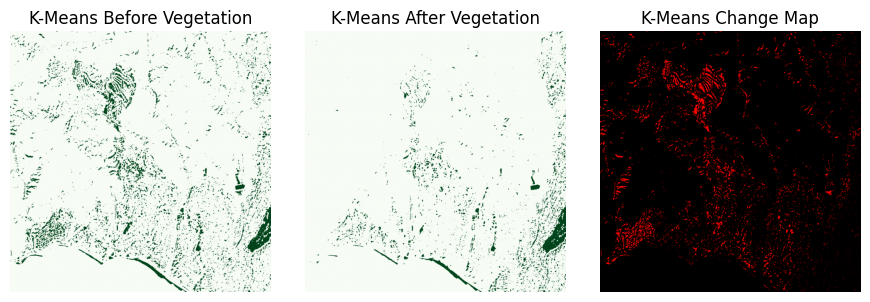

In [ ]:
import matplotlib.pyplot as plt

# CNN
plt.figure(figsize=(9, 3))

# CNN Before Vegetation
plt.subplot(1, 3, 1)
plt.imshow(1-cnn_before_predictions[0, :, :, 0], cmap='Greens')
plt.title("CNN Before Vegetation")
plt.axis('off')

# CNN After Vegetation
plt.subplot(1, 3, 2)
plt.imshow(1-cnn_after_predictions[0, :, :, 0], cmap='Greens')
plt.title("CNN After Vegetation")
plt.axis('off')

# CNN Change Map
plt.subplot(1, 3, 3)
plt.imshow(cnn_change_map)
plt.title("CNN Change Map")
plt.axis('off')

plt.tight_layout()
plt.show()

# NDVI
plt.figure(figsize=(9, 3))

# NDVI Before Vegetation
plt.subplot(1, 3, 1)
plt.imshow(ndvi_before_vegetation, cmap='Greens')
plt.title("NDVI Before Vegetation")
plt.axis('off')

# NDVI After Vegetation
plt.subplot(1, 3, 2)
plt.imshow(ndvi_after_vegetation, cmap='Greens')
plt.title("NDVI After Vegetation")
plt.axis('off')

# NDVI Change Map
plt.subplot(1, 3, 3)
plt.imshow(ndvi_change_map)
plt.title("NDVI Change Map")
plt.axis('off')

plt.tight_layout()
plt.show()

# K-Means
plt.figure(figsize=(9, 3))

# K-Means Before Vegetation
plt.subplot(1, 3, 1)
plt.imshow(kmeans_before_vegetation, cmap='Greens')
plt.title("K-Means Before Vegetation")
plt.axis('off')

# K-Means After Vegetation
plt.subplot(1, 3, 2)
plt.imshow(kmeans_after_vegetation, cmap='Greens')
plt.title("K-Means After Vegetation")
plt.axis('off')

# K-Means Change Map
plt.subplot(1, 3, 3)
plt.imshow(kmeans_change_map)
plt.title("K-Means Change Map")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

# ==================== Chi-square Test Implementation ==================== #
# Count vegetation/non-vegetation pixels
n_veg_before = np.sum(ndvi_before_vegetation)
n_nonveg_before = ndvi_before_vegetation.size - n_veg_before

n_veg_after = np.sum(ndvi_after_vegetation)
n_nonveg_after = ndvi_after_vegetation.size - n_veg_after

# Create 2x2 contingency table
contingency_table = [
    [n_veg_before, n_nonveg_before],  # Pre-fire distribution
    [n_veg_after, n_nonveg_after]     # Post-fire distribution
]

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# ==================== Generate English Report ==================== #
print(f"""
[NDVI Vegetation Change Chi-square Test Report]
----------------------------------------
Null Hypothesis (H0): No significant difference in vegetation proportion before/after wildfire

Observed Frequencies:
               Vegetation Pixels  Non-Vegetation Pixels
----------------------------------------
Pre-fire       {n_veg_before:<12d}    {n_nonveg_before}
Post-fire      {n_veg_after:<12d}    {n_nonveg_after}

Test Results:
- Chi-square statistic = {chi2_stat:.2f}
- Degrees of freedom (dof) = {dof}
- P-value = {p_value:.8f}
- Significance conclusion (α=0.05): {"Significant change (reject H0)" if p_value < 0.05 else "No significant change (fail to reject H0)"}

Expected Frequencies (if H0 holds):
               Vegetation Pixels  Non-Vegetation Pixels
----------------------------------------
Pre-fire       {expected[0][0]:<12.1f}    {expected[0][1]:.1f}
Post-fire      {expected[1][0]:<12.1f}    {expected[1][1]:.1f}
""")


[NDVI Vegetation Change Chi-square Test Report]
----------------------------------------
Null Hypothesis (H0): No significant difference in vegetation proportion before/after wildfire

Observed Frequencies:
               Vegetation Pixels  Non-Vegetation Pixels
----------------------------------------
Pre-fire       3746642         2246062
Post-fire      494992          5497712

Test Results:
- Chi-square statistic = 3858107.11
- Degrees of freedom (dof) = 1
- P-value = 0.00000000
- Significance conclusion (α=0.05): Significant change (reject H0)

Expected Frequencies (if H0 holds):
               Vegetation Pixels  Non-Vegetation Pixels
----------------------------------------
Pre-fire       2120817.0       3871887.0
Post-fire      2120817.0       3871887.0

